In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import lightning as pl
import torchmetrics
import comet_ml
import os
from lightning.pytorch import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from comet_ml import Experiment

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("danrasband/asl-alphabet-test")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Hyperbook\.cache\kagglehub\datasets\danrasband\asl-alphabet-test\versions\1


In [7]:
dataset1_pth = r"C:\Users\Hyperbook\.cache\kagglehub\datasets\danrasband\asl-alphabet-test\versions\1"

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("debashishsau/aslamerican-sign-language-aplhabet-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Hyperbook\.cache\kagglehub\datasets\debashishsau\aslamerican-sign-language-aplhabet-dataset\versions\1


In [8]:
dataset2_pth = r"C:\Users\Hyperbook\.cache\kagglehub\datasets\debashishsau\aslamerican-sign-language-aplhabet-dataset\versions\1"

## CUDA SETUP

In [9]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        torch.set_default_dtype(torch.float32)
    return device

device = setup_device()
print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Using cuda device


In [72]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset

# Transformacje
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.CenterCrop((190,190)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Values calculated from the ImageNet dataset

])

import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.data_dirs = data_dirs  # List of paths to data folders
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes_to_ignore = ["del", "nothing", "space"]

        # Gather all class names, ignoring specified classes
        self.classes = sorted([
            class_name for class_name in os.listdir(self.data_dirs[0]) 
            if class_name not in self.classes_to_ignore
        ])

        # Create a mapping from class names to indices
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes)}

        # Load images and labels
        for data_dir in self.data_dirs:
            for class_name in self.classes:
                class_dir = os.path.join(data_dir, class_name)
                if os.path.exists(class_dir):  # Ensure class directory exists
                    for img_name in os.listdir(class_dir):
                        img_path = os.path.join(class_dir, img_name)
                        if img_path.endswith(('.png', '.jpg', '.jpeg')):  # Check file extensions
                            self.images.append(img_path)
                            self.labels.append(self.class_to_idx[class_name])  # Use mapped class index

        print("Classes:", self.classes)
        print("Class to Index Mapping:", self.class_to_idx)

    def __len__(self):
        return len(self.images)  # Return the number of images loaded

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        label = self.labels[idx]  # Get the corresponding label
        return image, label



In [73]:
data_dirs = [
    dataset1_pth,
    dataset2_pth
]

combined_dataset = CustomDataset(data_dirs, transform=transform)

len(combined_dataset)


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Class to Index Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


780

In [58]:
# Sanity check
print("Dataset len:")
print(len(combined_dataset))

# print("\nDataset classes:")
# print(combined_dataset.classes)

print("\nRandom images from dataset:")
img, label = combined_dataset[random.randint(0, len(combined_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()


Dataset len:
0

Random images from dataset:


ValueError: empty range for randrange() (0, 0, 0)

## DATASET

In [11]:
transform = transforms.Compose([
    # transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Values calculated from the ImageNet dataset
])

class Dataset(Dataset):
    def __init__(self, root_dir, dataset_type, transform=None):
        self.root_dir = root_dir
        self.dataset_type = dataset_type
        self.transform = transform
        self.classes_to_ignore = ["del", "nothing", "space"]

        self.classes = sorted([class_name for class_name in os.listdir(self.root_dir) if class_name not in self.classes_to_ignore])


        # self.classes if a dataset type is "test"
        if self.dataset_type == "test":
            test_classes = []
            for class_ in self.classes:
                if class_.endswith(".jpg"):
                    class_name = class_.replace("_test.jpg", "")
                elif class_.endswith(".png"):
                    class_name = class_.replace("_test.png", "")
                if class_name not in self.classes_to_ignore:
                    test_classes.append(class_name)
            self.classes = test_classes

        # Maping class names to numbers 
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes) if class_name not in self.classes_to_ignore}

    def __len__(self):
        if self.dataset_type == "train":
            dataset_len = sum([len(os.listdir(self.root_dir + class_)) for class_ in self.classes])
        elif self.dataset_type == "test":
            dataset_len = len(self.classes)
        return dataset_len
    
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("Index out of bounds")
        
        if self.dataset_type == "train":
            items_in_class = 3000 # Every class has 3000 items
            class_ = self.classes[index // items_in_class]
            image_path = os.path.join(self.root_dir, class_) + f"/{class_}{index % (items_in_class)+1}.jpg"
            # Applying label maping 
            label = self.class_to_idx[class_]
            
        elif self.dataset_type == "test":
            class_ = self.classes[index]
            image_path = os.path.join(self.root_dir, class_) + f"_test.jpg"
            # Applying label maping 
            label = self.class_to_idx[class_]

        # Loading image with cv2
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        # Converting to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # Transform
        if self.transform:
            image = self.transform(Image.fromarray(image))
        
        return image, label
        

In [12]:
# Train dataset and dataloader initialization
train_dataset = Dataset(root_dir="./dataset/asl_alphabet_train/", 
                        transform=transform,
                        dataset_type="train")

Dataset len:
78000

Dataset classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random images from dataset:


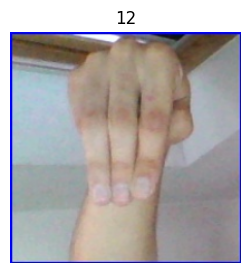

In [13]:
# Sanity check
print("Dataset len:")
print(len(train_dataset))

print("\nDataset classes:")
print(train_dataset.classes)

print("\nRandom images from dataset:")
img, label = train_dataset[random.randint(0, len(train_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()


In [14]:
# Train dataset and dataloader initialization
test_dataset = Dataset(root_dir="./dataset/asl_alphabet_test/", 
                        transform=transform,
                        dataset_type="test")

Dataset len:
26

Dataset classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random image from dataset:


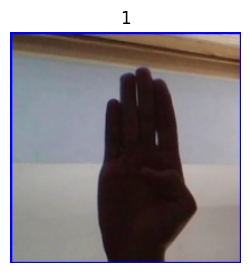

In [15]:
# Sanity check
print("Dataset len:")
print(len(test_dataset))

print("\nDataset classes:")
print(test_dataset.classes)

print("\nRandom image from dataset:")
img, label = test_dataset[random.randint(0, len(test_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()